In [47]:
# import libraries
from matipo import SEQUENCE_DIR, GLOBALS_DIR
from matipo.sequence import Sequence
from matipo.util.autophase import autophase
from matipo.util.decimation import decimate
from matipo.util.fft import fft_reconstruction, get_freq_spectrum
from matipo.util.etl import deinterlace
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import ipyvolume as ipv

# progress_handler for Sequence.run() that simply prints the progress
def print_progress(p, l):
    if p%(l//4)==0: # only print 4 times per run
        print(p, '/', l)

# find frequency utility: runs FID, calculates and returns centre frequency
FIDseq = Sequence(SEQUENCE_DIR+'FID.py')
FIDseq.loadpar(GLOBALS_DIR+'frequency.yaml')
async def findfreq():
    """ Runs FID and returns centre frequency calculated by integrating the spectrum"""
    FIDseq.loadpar(GLOBALS_DIR+'hardpulse_90.yaml')
    FIDseq.loadpar(GLOBALS_DIR+'shims.yaml')
    FIDseq.setpar(t_dw=64e-6, n_samples=1000, n_scans=1)
    await FIDseq.run()
    _, fft = get_freq_spectrum(FIDseq.data, FIDseq.par.t_dw)
    fft_abs = np.abs(fft)
    fft_abs_sum = np.cumsum(fft_abs)
    # find index corresponding to half the integral of fft_abs, rounded down
    f_index = np.searchsorted(fft_abs_sum, fft_abs_sum[-1]/2.0)
    # interpolate the index to get the true halfway point
    f_index += (fft_abs_sum[-1]/2.0 - fft_abs_sum[f_index-1])/(fft_abs_sum[f_index] - fft_abs_sum[f_index-1]) - 1
    # calculate the frequency corresponding to the index
    freq = FIDseq.par.f + (1/FIDseq.par.t_dw)*(f_index/FIDseq.par.n_samples-0.5)
    FIDseq.setpar(f=freq) # update frequency parameter for next run
    return freq

# based on https://stackoverflow.com/a/44164075
def sphere_points(num_pts):
    """ Generates N points on the unit sphere that are fairly evenly spaced """
    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/num_pts)
    theta = np.pi * (1 + 5**0.5) * indices
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
    return np.array([x, y, z]).T # format into array of x,y,z arrays

In [48]:
await findfreq()

15088257.741242502

In [62]:
# set save directory and base file name
SAVE_DIR = '/home/data/RAREDTI'
SAVE_NAME = 'spring_onion_3x18'

# make the save directory if it doesn't exist
Path(SAVE_DIR, SAVE_NAME).mkdir(parents=True, exist_ok=True)

In [56]:
N_mag = 3 # number of magnitudes per direction
N_directions = 18 # number of directions
diffgrad_mag_max = 0.25 # uncalibrated, just proportion of maximum possible amplitude
diffgrad_directions = sphere_points(N_directions)
# generate gradient magnitudes in such a way that the b-values will be linearly increasing
diffgrad_mag = diffgrad_mag_max*np.sqrt(np.linspace(0, 1, N_mag+1)[1:]) # Don't include 0 gradient magnitude here
# order gradients to run different magnitudes in the same direction consecutively
diffgrad = np.reshape(diffgrad_directions[:,np.newaxis,:]*diffgrad_mag[np.newaxis,:,np.newaxis], (N_directions*N_mag, 3))
# prepend [0,0,0] gradient
diffgrad = np.vstack([[0,0,0], diffgrad])

# # visualise gradient vectors
# fig = ipv.figure()
# ipv.xyzlim(diffgrad_mag_max)
# ipv.scatter(diffgrad[:,0], diffgrad[:,1], diffgrad[:,2], size=3, marker="sphere")
# ipv.show()

### Diffusion Weighted Imaging using Pulsed Gradient Spin Echo module with RARE readout

Pulse sequence `PGSE_RARE.py`:

`90 pulse | delay | diffusion gradient | 180 pulse | diffusion gradient | delay | read prephase gradient | [ 180 pulse | +ve phase gradient | read gradient + acquisition | -ve phase gradient ]`

Notes:
 - `[]` repeats for `n_ETL`, stepping through phase gradients.
 - The Diffusion gradient has amplitude `g_diff` and flat time `t_diff`.
 - The echo time of the first echo is different from the RARE readout echos.
 - The delays before and after the diffusion module are automatically calculated to align the echos.

In [57]:
# load sequence from local directory
seq = Sequence('PGSE_RARE.py')

seq.loadpar(GLOBALS_DIR+'shims.yaml')
seq.loadpar(GLOBALS_DIR+'frequency.yaml')
seq.loadpar(GLOBALS_DIR+'hardpulse_180.yaml')

# use hardpulse for projection or softpulse & non-zero g_slice for slice
# seq.loadpar(GLOBALS_DIR+'hardpulse_90.yaml')
seq.loadpar(GLOBALS_DIR+'softpulse_90_8.0mm.yaml')
g_slice = seq.par.g_slice*np.array([0, 0, 1.0]) # slice through Z axis

DECIMATION = 4

seq.setpar(
    g_slice=g_slice, 
    
    n_ETL=64, # Echo Train Length, number of echos in each CPMG train, reduce if sample has short T2
    
    # for 2D, just use phase_2 and set n_phase_1 to 1 with no gradient
    n_phase_1=1,
    g_phase_1=(0,0,0),
    
    t_diff=24e-3, # diffusion gradient ON time
    
    # 32 phase steps
    n_phase_2=64, # changes resolution
    g_phase_2=(0,-0.5,0),
    
    # frequency encode with oversampling for flat filtering
    t_dw=10e-6, # changes FOV
    n_samples=64*DECIMATION,  # changes resolution
    g_read=(0.3,0,0), # changes FOV
    
    t_end=2,
    n_scans=4
)

# print out the parameter set for reference
print(seq.par)

# set calculated read gradient pulse duration
seq.setpar(t_read=seq.par.t_dw*seq.par.n_samples)
# set phase  pulse duration so that the area is half the read pulse area
seq.setpar(t_phase=np.abs(np.linalg.norm(seq.par.g_read)/np.linalg.norm(seq.par.g_phase_2))*seq.par.t_read/2)

# not perfectly accurate, but close enough
# (doesn't account full sequence time, only repetition delay)
t_echo = seq.par.t_180 + 4*seq.par.t_grad_ramp + 2*seq.par.t_phase + seq.par.t_read
time_est_s = len(diffgrad)*(seq.par.n_scans*seq.par.n_phase_1*(seq.par.n_phase_2//seq.par.n_ETL+1)*(seq.par.n_ETL*t_echo+seq.par.t_end))
print('total time est. (mins):', time_est_s/60)

# save gradient table
np.savetxt(f'{SAVE_DIR}/{SAVE_NAME}/gradient_table.txt', diffgrad)
for i, G in enumerate(diffgrad):
    print(f'{i+1}/{len(diffgrad)} Diff Grad: {np.array2string(G, precision=2, suppress_small=True)}')
    freq = await findfreq()
    seq.setpar(f=freq, g_diff=G)
    await seq.run()
    y_ = decimate(
        deinterlace(seq.data, seq.par.n_ETL, 1, seq.par.n_phase_2, seq.par.n_samples), 
        DECIMATION, axis=1)
    # save data and parameters
    np.save(f'{SAVE_DIR}/{SAVE_NAME}/{i}', y_)
    seq.savepar(f'{SAVE_DIR}/{SAVE_NAME}/{i}.yaml')

# compress data directory to archive
import shutil
shutil.make_archive(f'{SAVE_DIR}/{SAVE_NAME}', 'zip', f'{SAVE_DIR}/{SAVE_NAME}')

ParameterSet(n_scans=4, f=15087799.969546732, a_90=0.23054716093001523, t_90=0.00019999999999999998, f_slice_offset=0.0, bw_90=25600.0, a_180=0.748218201305545, t_180=3.2e-05, t_diff=0.024, g_diff=array([0., 0., 0.]), t_dw=1e-05, n_samples=256, t_read=0.00032, t_phase=0.00016, n_phase_1=1, n_phase_2=64, n_ETL=64, t_end=2.0, g_slice=array([0. , 0. , 0.4]), g_read=array([0.3, 0. , 0. ]), g_phase_1=array([0., 0., 0.]), g_phase_2=array([ 0. , -0.5,  0. ]), t_spoil=0.001, g_spoil=array([0., 0., 0.]), t_grad_ramp=0.0001, n_grad_ramp=10, tweak_unslice=0.0, p_90_offset=0.0, shim_x=0.26415841489561137, shim_y=0.07403496048808061, shim_z=-0.31902529361193027, shim_z2=-0.1569555466851132, shim_zx=-0.48159797006250255, shim_zy=0.11183548005920328, shim_xy=0.02238353755674853, shim_x2y2=0.1844255846462328, enable_dummy_run=False)
total time est. (mins): 16.791808
1/55 Diff Grad: [0. 0. 0.]
2/55 Diff Grad: [ 0.02 -0.04  0.14]
3/55 Diff Grad: [ 0.02 -0.06  0.19]
4/55 Diff Grad: [ 0.03 -0.08  0.24]
5/

'/home/data/RAREDTI/shim_10dir_G25.zip'

#### Load saved data

In [58]:
ys = []
for i, G in enumerate(diffgrad):
    ys.append(np.load(f'{SAVE_DIR}/{SAVE_NAME}/{i}.npy'))

#### Fourier Reconstruction & Masking

In [59]:
upscale=2
blur=2
ims = []
for i, G in enumerate(diffgrad):
    ims.append(np.abs(fft_reconstruction(ys[i], upscale_factor=upscale, gaussian_blur=blur)))

cmap = 'gray'
vmin = np.min(ims[0])
vmax = np.max(ims[0])

mask = np.copy(ims[0])
thresh = 0.25*np.max(mask) # adjust to alter the threshold, quarter of maximum is a good starting point
mask[mask > thresh] = 1
mask[mask <= thresh] = np.nan

#### Diffusion Weighted Images

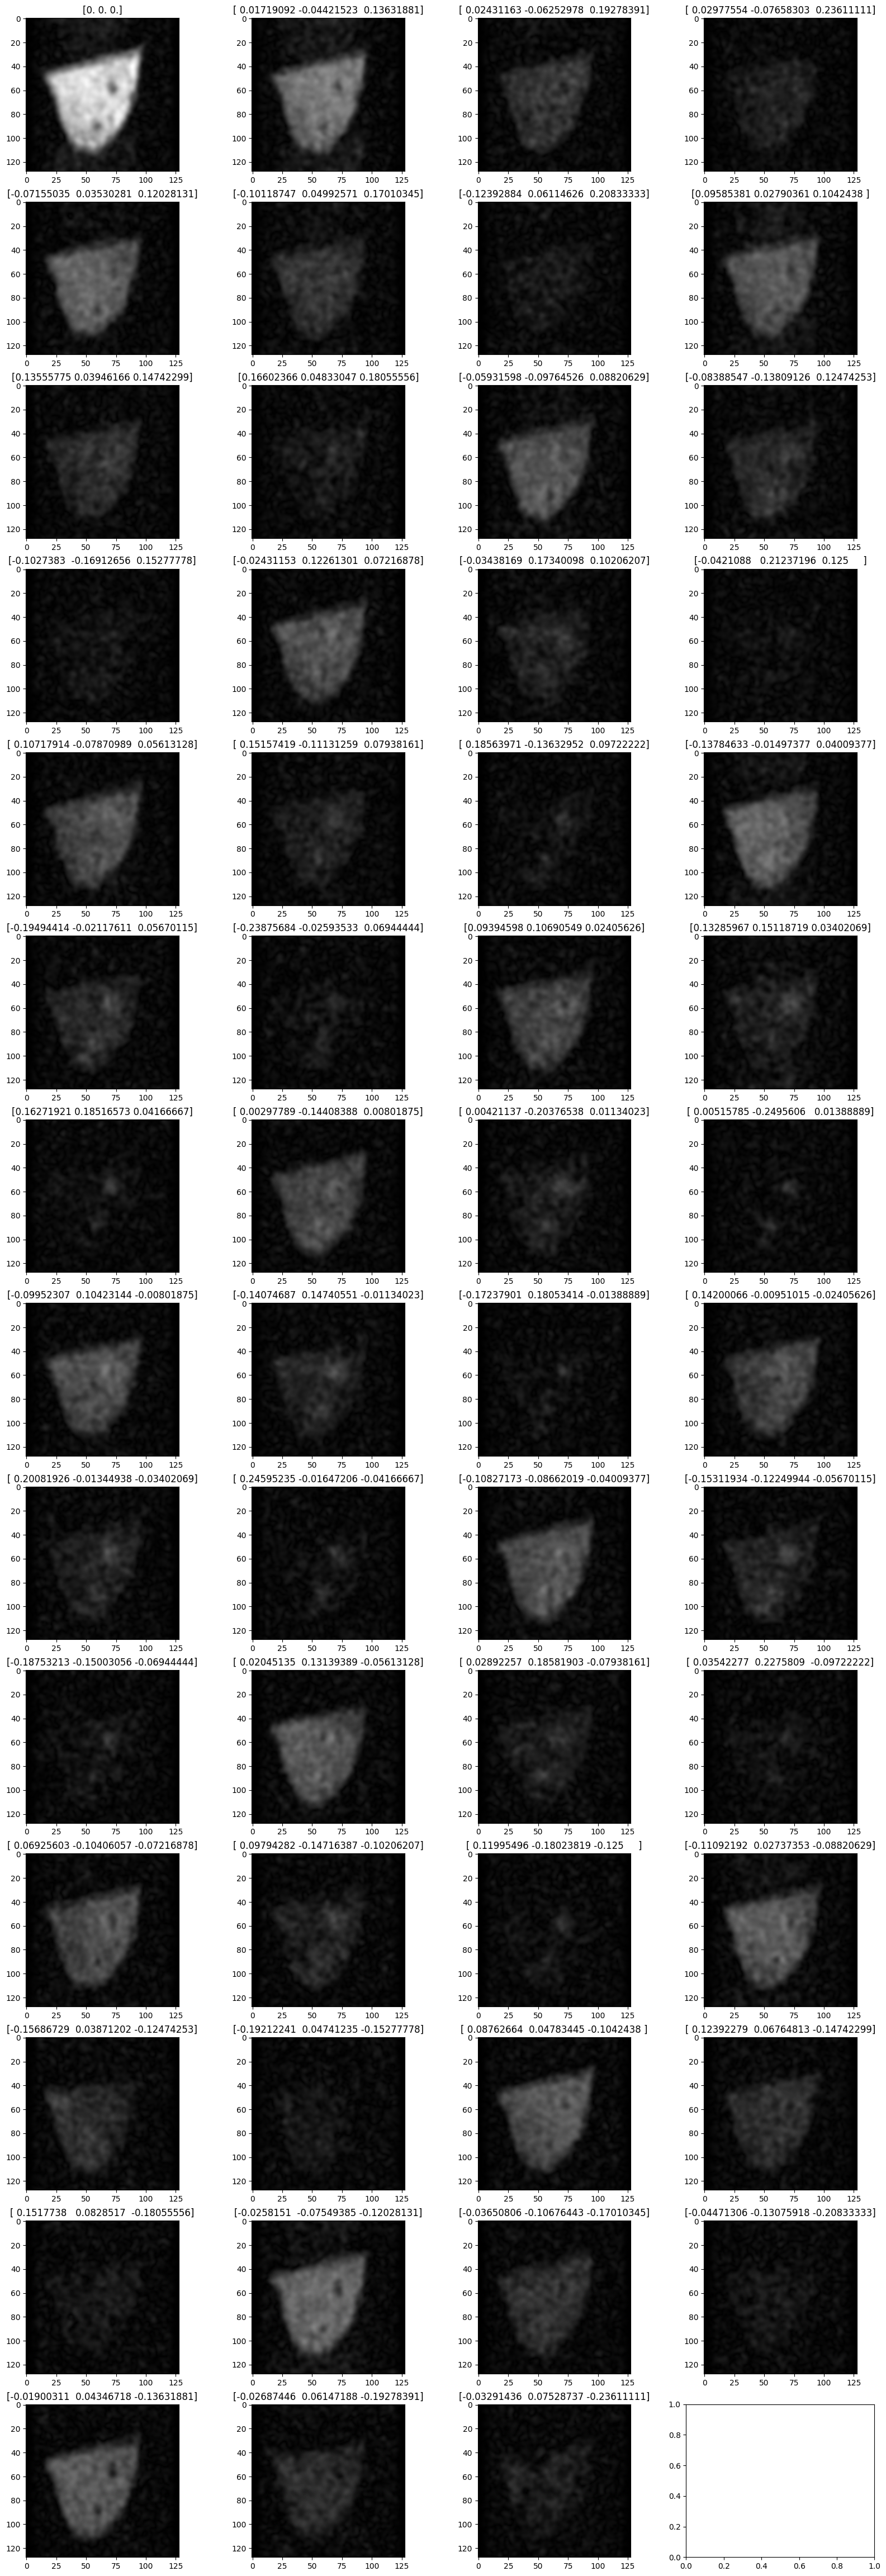

In [60]:
fig, axes = plt.subplots(nrows=(len(diffgrad)//4+1), ncols=4, figsize=(20,len(diffgrad)+4))
for i, G in enumerate(diffgrad):
    axes[i//4, i%4].imshow(ims[i], cmap=cmap, vmin=vmin, vmax=vmax)
    axes[i//4, i%4].set_title(G)
plt.show()

#### ADC Maps

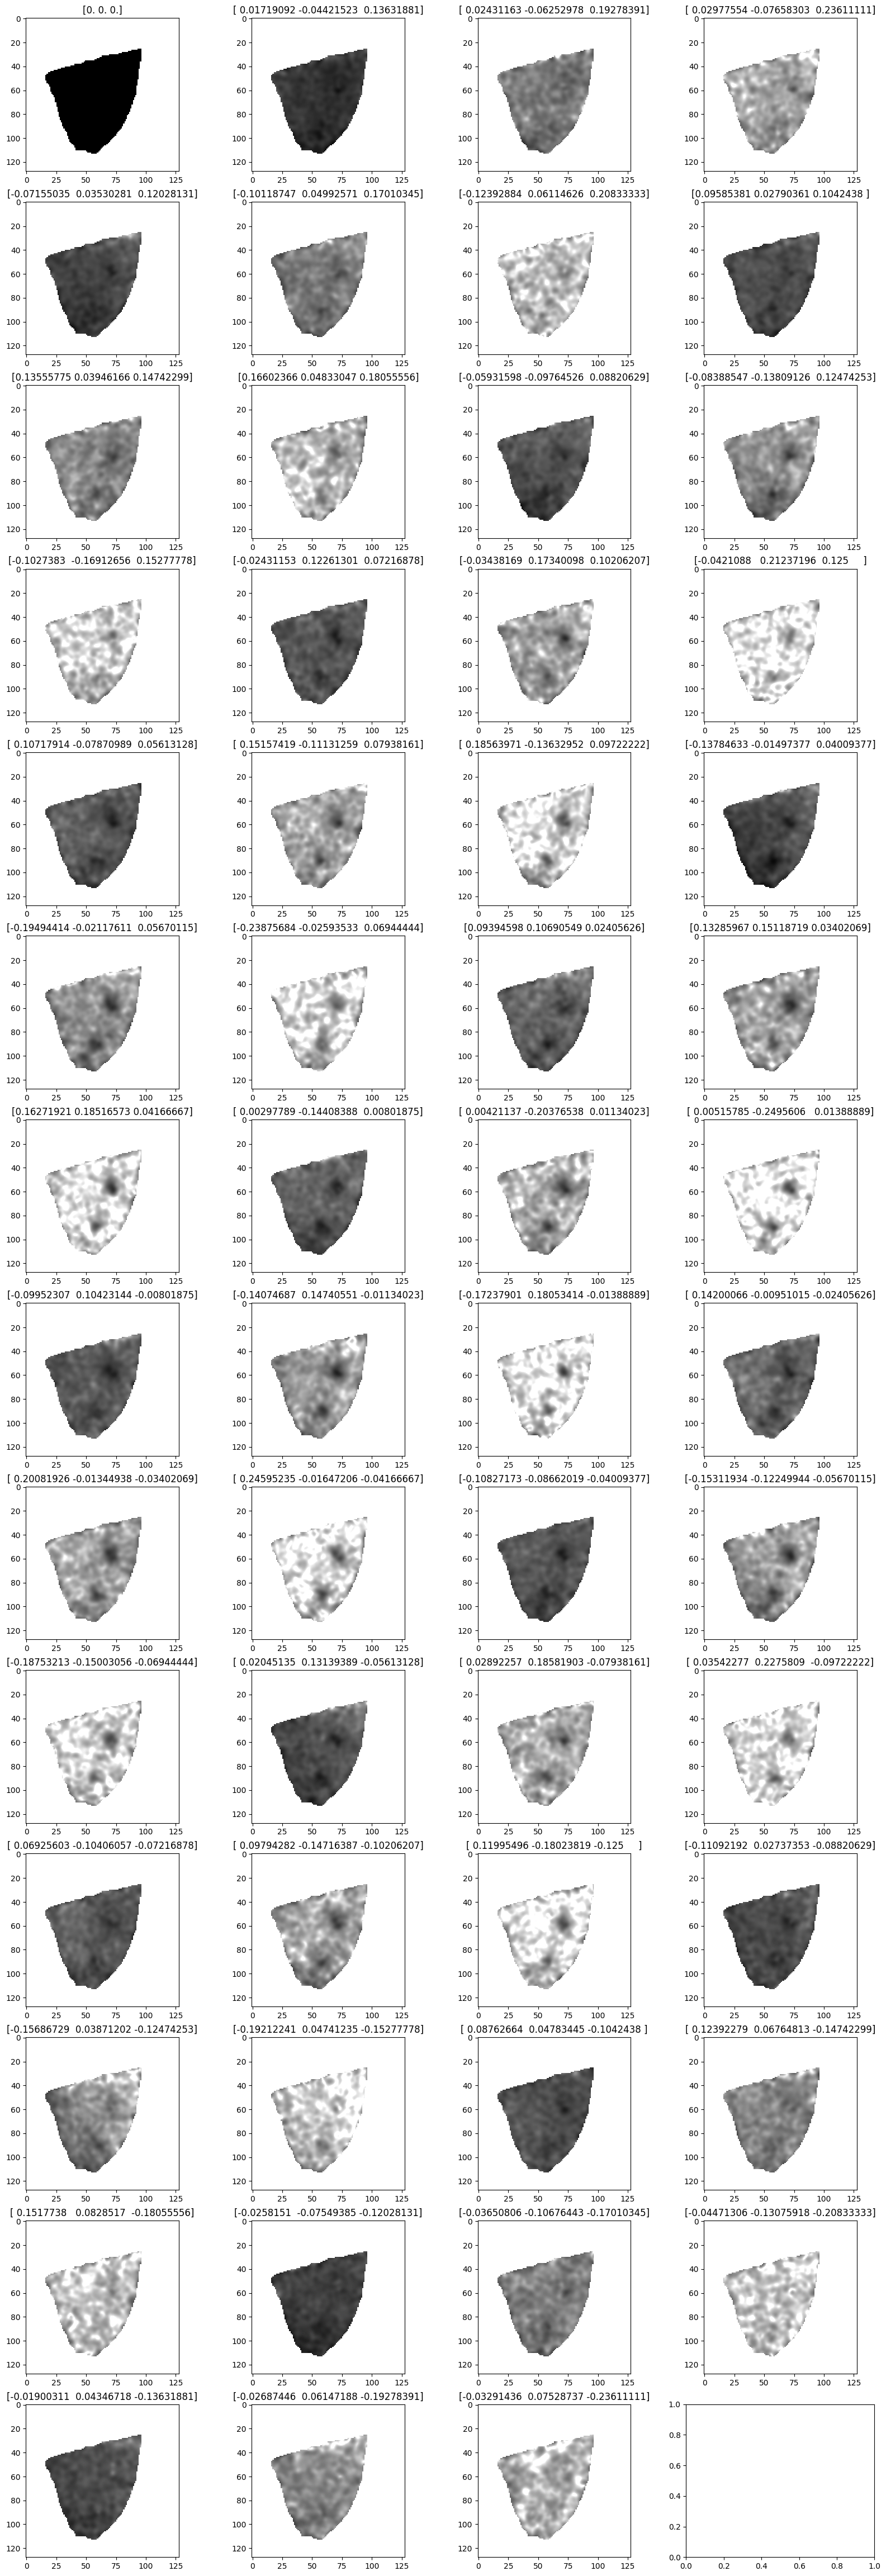

In [61]:
fig, axes = plt.subplots(nrows=(len(diffgrad)//4+1), ncols=4, figsize=(20,len(diffgrad)+4))
for i,G in enumerate(diffgrad):
    axes[i//4, i%4].imshow(
        mask*-np.log(ims[i]/ims[0]), # calculate ADC and apply mask
        cmap=cmap,
        vmin=0, # fixed vmin
        vmax=3) # fixed vmax so that plots are comparable
    axes[i//4, i%4].set_title(G) 
plt.show()